## Simulate theoretical inter-ROI distance

Gabriella Chan 29/08/23 <br>
gabriella.chan@monash.edu <br>
Monash University

During the generation of the rewired null model, node connections may be generated that do not exist canonically. Here we theoretically simulate hypothetical inter-ROI distance if such tracts were to exist. We:
1. Calculate the mean distance between ROIs by taking pairwise euclidean voxel distance
2. Take linear regression between euclidean and experimental distance (from 42regions/sc40) of connected ROIs 
3. Compute theoretical distance

In [1]:
import nibabel as nib
import statistics as stats
import csv
from scipy.spatial.distance import pdist
import numpy as np


In [186]:
# Loads atlas. Here we use the Desikan Killiany atlas 
atlas_img = nib.load('/fs03/kg98/gchan/Atlases/Tian/Schaefer_Tian/reordered/Schaefer2018_100Parcels_7Networks_order_Tian_Subcortex_S2_MNI152NLin6Asym_1mm_reordered.nii')
# atlas_img = nib.load('/fs03/kg98/gchan/Atlases/Tian/Schaefer_Tian/reordered/Schaefer2018_300Parcels_7Networks_order_Tian_Subcortex_S2_MNI152NLin6Asym_1mm_reordered.nii')
# determine atlas shape
x, y, z = atlas_img.shape
n_rois = 66

# Load ifod distance matrix
sconn_len = np.loadtxt('./data/s132_len.csv', delimiter=',')
sconn_35 = np.loadtxt('./data/s132_len_35.csv', delimiter=',')


# check shape
print(atlas_img.shape)
atlas_data = atlas_img.get_fdata()

(182, 218, 182)


In [187]:
# for each ROI generates a list of voxel coordinates

# initialises variables
# rois is a dictionary of all voxel coordinates per roi
# rois = {ROI 1: [X, Y, Z], [X, Y, Z],...
#         ROI 2: [X, Y, Z], [X, Y, Z],...
#        }

rois = {}
coords = np.argwhere((atlas_data > 0) & (atlas_data <= n_rois))

for coord in coords:
    i, j, k = coord
    roi = int(atlas_data[i, j, k])
    if roi in rois:
        rois[roi].append([i, j, k])
    else:
        rois[roi] = [[i, j, k]]


In [188]:
# Calculate geometric median for each ROI
# from https://stackoverflow.com/questions/30299267/geometric-median-of-multidimensional-points

from scipy.spatial.distance import cdist, euclidean

def geometric_median(X, eps=1e-5):
    y = np.mean(X, 0)

    while True:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1

        y = y1

geo_medians = {}
for roi, coords in rois.items():
    coords_array = np.array(coords)
    geo_medians[roi] = geometric_median(coords_array)

# print(geo_medians)

In [189]:
# Calculate distance matrix based on geometric median

geo_med = np.array([geo_medians[roi] for roi in range(1, n_rois+1)])
dist_mat = cdist(geo_med, geo_med)

# print(dist_mat)

In [190]:
from sklearn.linear_model import LinearRegression

mask = (sconn_35 != 0)
euc_train = dist_mat[mask].flatten().reshape(-1, 1)
emp = sconn_35[mask].flatten().reshape(-1, 1)
reg = LinearRegression().fit(euc_train, emp)
# Predict missing values in sconn_35 using the linear regression model
euc_test = dist_mat[~mask].flatten().reshape(-1, 1)
predicted_distances = reg.predict(euc_test)

sconn_35_filled = np.copy(sconn_35)
sconn_35_filled[~mask] = predicted_distances.flatten()

# Replace zero values in sconn_35 with predicted distances
np.fill_diagonal(sconn_35_filled, 0)

print(sconn_35_filled)


[[  0.          56.3441246   39.56960407 ...  61.82802534  78.44424843
   74.01823173]
 [ 56.3441246    0.          30.62197651 ...  98.13633061 121.3194831
  112.32452306]
 [ 39.56960407  30.62197651   0.         ...  95.3810654  101.20418643
   91.93303474]
 ...
 [ 61.82802534  98.13633061  95.3810654  ...   0.          47.34300151
   32.6035047 ]
 [ 78.44424843 121.3194831  101.20418643 ...  47.34300151   0.
   49.9648181 ]
 [ 74.01823173 112.32452306  91.93303474 ...  32.6035047   49.9648181
    0.        ]]


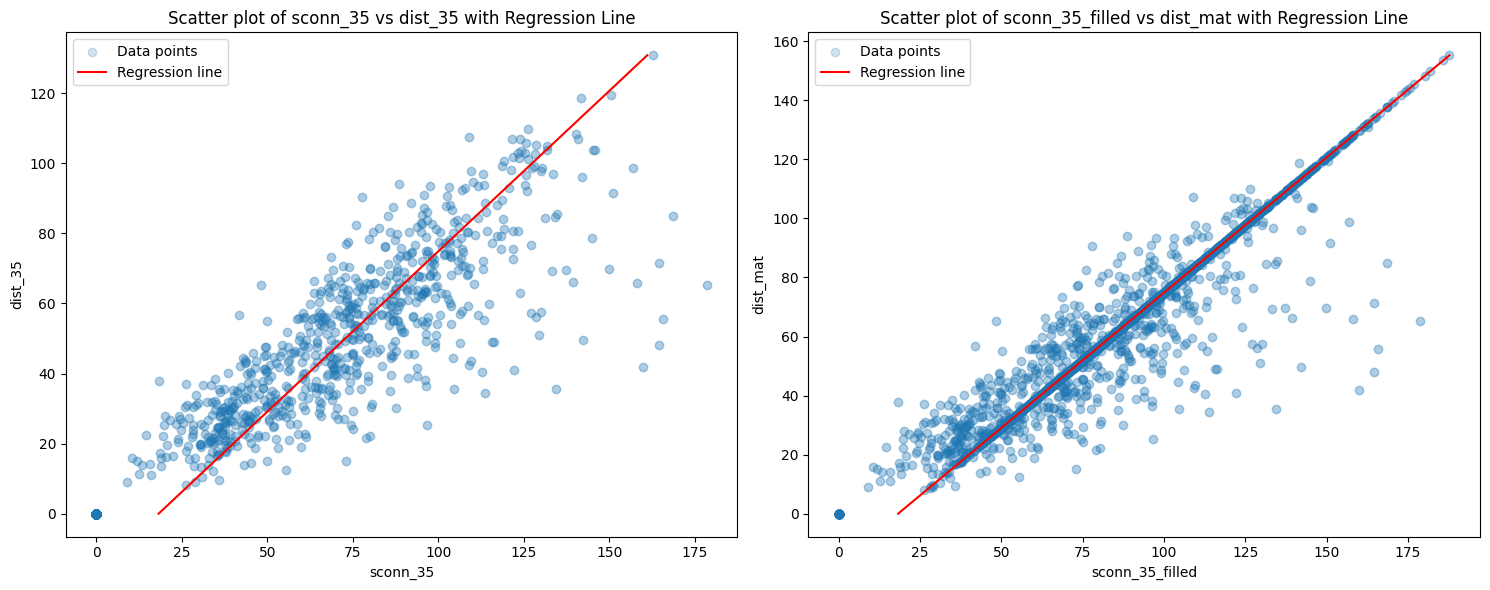

In [191]:
dist_35 = np.array(dist_mat)
dist_35[~mask] = 0

# Flatten the matrices to create scatter plot
sconn_35_flat = sconn_35.flatten()
dist_35_flat = dist_35.flatten()
sconn_35_filled_flat = sconn_35_filled.flatten()
dist_mat_flat = dist_mat.flatten()

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First subplot: sconn_35 vs dist_35
axs[0].scatter(sconn_35_flat, dist_35_flat, alpha=0.2, label='Data points')
y_vals = np.linspace(min(dist_35_flat), max(dist_35_flat), 100).reshape(-1, 1)
x_vals = reg.predict(y_vals)
axs[0].plot(x_vals, y_vals, color='red', label='Regression line')
axs[0].set_xlabel('sconn_35')
axs[0].set_ylabel('dist_35')
axs[0].set_title('Scatter plot of sconn_35 vs dist_35 with Regression Line')
axs[0].legend()

# Second subplot: sconn_35_filled vs dist_mat
axs[1].scatter(sconn_35_filled_flat, dist_mat_flat, alpha=0.2, label='Data points')
y_vals_filled = np.linspace(min(dist_mat_flat), max(dist_mat_flat), 100).reshape(-1, 1)
x_vals_filled = reg.predict(y_vals_filled)
axs[1].plot(x_vals_filled, y_vals_filled, color='red', label='Regression line')
axs[1].set_xlabel('sconn_35_filled')
axs[1].set_ylabel('dist_mat')
axs[1].set_title('Scatter plot of sconn_35_filled vs dist_mat with Regression Line')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# np.savetxt('./results/s132_len.csv', sconn_35_filled, delimiter=',')
np.savetxt('./results/s332_len.csv', sconn_35_filled, delimiter=',')

In [193]:
# check if geometric median lies within ROI

mismatches = []
for roi, median in geo_medians.items():
    median = np.round(median).astype(int)
    atlas_roi = atlas_data[median[0], median[1], median[2]]
    
    if roi != atlas_roi:
        mismatches.append([roi, atlas_roi])
        print(roi, atlas_roi, median)

# Compare geometric median to centroid

centroids = {}
for roi, coords in rois.items():
    coords_array = np.array(coords)
    centroid = np.mean(coords_array, axis=0)
    centroids[roi] = centroid

print(centroids)

for mismatch in mismatches:
    roi = mismatch[0]
    print(f'roi: {roi}, median:{geo_medians[roi]}, centroid:{centroids[roi]}')


15 0.0 [101  99 137]
46 0.0 [100 172 112]
32 0.0 [123 127  36]
{9: array([97.25599534, 44.43050058, 97.96251455]), 5: array([95.45960929, 33.87051214, 69.21211721]), 6: array([102.022142  ,  60.47629362,  78.06919374]), 50: array([ 95.75211804,  72.94098049, 104.944693  ]), 36: array([ 99.40077643,  52.87759763, 109.605161  ]), 44: array([ 95.89884499, 172.45707349,  71.32928713]), 20: array([ 95.92902081,  65.95870302, 128.53960316]), 37: array([ 93.80493889,  99.68321277, 104.51583936]), 15: array([100.93194081,  99.58197553, 135.65799455]), 57: array([ 96.0070922 , 115.0141844 ,  78.37234043]), 28: array([ 95.15232048, 145.56216682, 105.64926309]), 30: array([ 96.16540116, 129.39610225, 133.36535054]), 46: array([ 99.97832229, 170.45864186, 111.78229735]), 31: array([103.84624167, 158.56809388,  52.06260704]), 3: array([106.36429322,  65.08420914,  65.28284288]), 49: array([101.37713004,  70.10695067,  85.04686099]), 29: array([100.57121826,  91.76352595, 117.80364372]), 56: array([

## We hop over to MATLAB

pdist2 in MATLAB will calculate the pairwise distances between lists of voxels

In [10]:
for roi in range(1,len(rois)+1):
    with open('./data/ROI_coordinates_300/ROI'+str(roi)+'coords.csv', 'w') as f:
        wr = csv.writer(f)
        wr.writerows(rois[roi])